/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1, Loss: 0.4481
Epoch 2, Loss: 0.2507
Epoch 3, Loss: 0.2301

Classification Report:
                 precision    recall  f1-score   support

Not LargeClass       0.89      0.97      0.93       160
    LargeClass       0.83      0.50      0.62        40

      accuracy                           0.88       200
     macro avg       0.86      0.74      0.78       200
  weighted avg       0.88      0.88      0.87       200



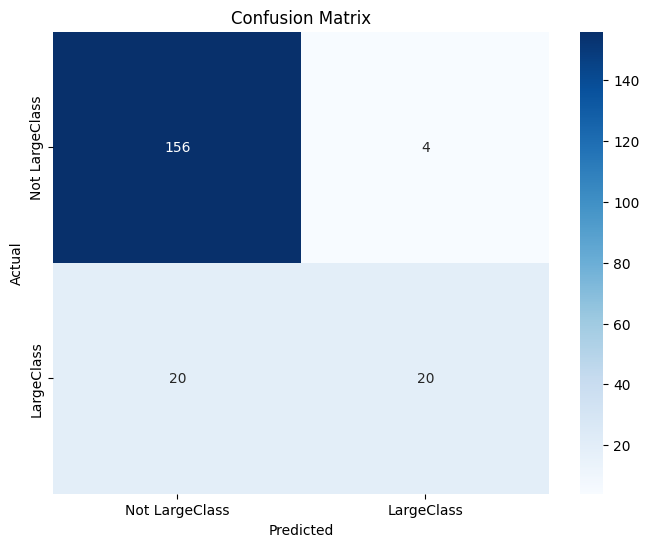

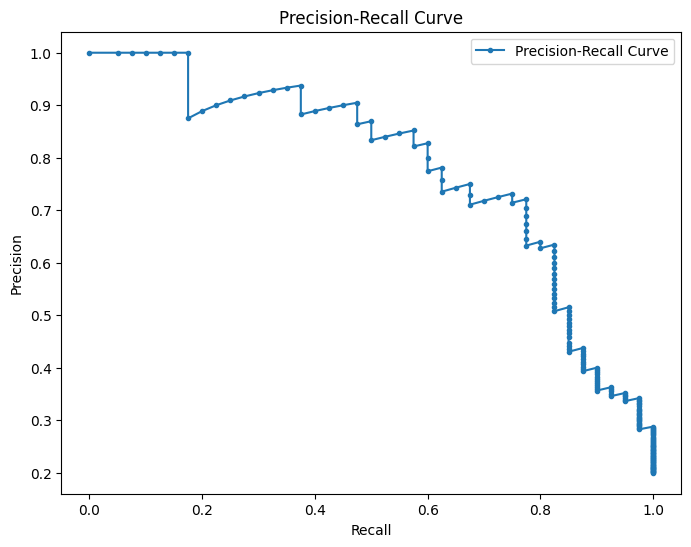

In [2]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define Feature-Aware BERT Architecture
class FeatureAwareBERT(nn.Module):
    def __init__(self, pretrained_model='bert-base-uncased', feature_dim=16, num_labels=2):
        super(FeatureAwareBERT, self).__init__()

        # BERT backbone
        self.bert = BertModel.from_pretrained(pretrained_model)

        # Feature embeddings (learned for feature names and values)
        self.feature_name_embedding = nn.Embedding(100, feature_dim)  # Assuming max 100 unique feature names
        self.feature_value_embedding = nn.Embedding(1000, feature_dim)  # Assuming max 1000 unique values

        # Fully connected classification head
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        # BERT encoder
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # Extract [CLS] token representation
        logits = self.fc(cls_embedding)  # Pass through classification head
        return logits

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        features = row.drop('LargeClass').to_dict()
        text = ', '.join([f"{key} is {value}" for key, value in features.items()])
        label = row['LargeClass']

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load Dataset
data_path = 'lcd.csv'
data_df = pd.read_csv(data_path)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Train-Test Split
train_data, test_data = train_test_split(data_df, test_size=0.2, random_state=42, stratify=data_df['LargeClass'])
train_dataset = CustomDataset(train_data, tokenizer, max_length=128)
test_dataset = CustomDataset(test_data, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize Model
model = FeatureAwareBERT(pretrained_model='bert-base-uncased', feature_dim=16, num_labels=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Optimizer and Loss Function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Training Function
def train_model():
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation Function
def evaluate_model():
    model.eval()
    preds, true_labels, probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            probabilities = torch.softmax(logits, dim=1)[:, 1]

            probs.extend(probabilities.cpu().numpy())
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Classification Report
    report = classification_report(true_labels, preds, target_names=['Not LargeClass', 'LargeClass'])
    print("\nClassification Report:\n", report)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not LargeClass', 'LargeClass'], yticklabels=['Not LargeClass', 'LargeClass'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(true_labels, probs)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

# Training Loop
for epoch in range(3):
    loss = train_model()
    print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

evaluate_model()
